# **Project: Dermatologist AI**

In [ ]:
!git clone https://github.com/udacity/dermatologist-ai.git
# !pip install -qq git+https://github.com/fastai/fastai
# !pip install fastbook

Cloning into 'dermatologist-ai'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 62 (delta 8), reused 2 (delta 0), pack-reused 33
Unpacking objects: 100% (62/62), done.


In [ ]:
# connect to google drive & get the images 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import numpy as np
import seaborn as sns

from fastbook import *
import fastai

from PIL import Image 
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import torch 
from torchvision import transforms as T

import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

### Utils 
[IMPORTANT] MAKE SURE TO CREATE A FOLDER TO STORE ALL OF THE CODE 

In [ ]:
def investigate(path):
  """
  This function reads in all the images in a specified path, stores a short 
  summary of image distributions (count of instances in each class)
  and a dataframe representation of image files along with their target.
    :param path: Path to a folder

  :returns: Two dataframes with short and long descriptions
  """
  # verify folder existance
  assert os.path.exists(path), 'Wrong path provided.'

  # get folder names
  contents = os.listdir(path)
  # create empty holders 
  content_dict = {}
  all_images = []
  classes = []

  # go over the folders and store the length
  for content in contents:
      files = os.listdir(os.path.join(path, content))
      content_dict[content] = len(files)
      # get all image names 
      all_images.append(files)
      classes.append([content for _ in range(len(files))])

  # flatten the array 
  if len(all_images) > 0:
      all_images = [img for x in all_images for img in x]
      classes = [cl for c in classes for cl in c]

  return (pd.DataFrame({'name': content_dict.keys(), 'length': content_dict.values()}), 
  pd.DataFrame({'image_name': all_images, 'class': classes}))


def print_summary(summary1, summary2, name):
  """
  This is a prettified representation to compare two dataframes. Pass in
  the summary gotten from "investigate" function. 

    :param summary1: First dataframe's content representation (image_name, length)
    :param summary2: Second dataframe's content representation (image_name, length)
    :param name: Name of the dataframe you're working with (for aesthetic purposes)

  """
  print(f'======== TRAIN FOR: {name} ========')
  print(summary1.sort_values(by='length', ascending=False))

  print(f'\n\n======== TEST FOR: {name} ========')
  print(summary2.sort_values(by='length', ascending=False))

In [ ]:
# create a dataloader 
def get_data_loader(path, bs=8, img_size=64, shuffle=True):
  datablock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        get_items=partial(get_image_files, folders=['train', 'val']),
                        splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                        get_y=parent_label,
                        item_tfms=[Resize((img_size, img_size), method='pad', pad_mode='zeros'), 
                                   ToTensor()],
                        batch_tfms=[*aug_transforms(flip_vert=True, max_rotate=15, 
                                                    pad_mode='zeros', max_lighting=0.6,
                                                    batch=True, ), 
                                   Normalize.from_stats(*imagenet_stats)])
  return datablock.dataloaders(path, bs=bs, drop_last=True, shuffle=shuffle)

def train_model(path, bs=8, img_size=64, shuffle=True, 
                freeze=3, epochs=10, model=resnet50):
  """
  Train and save best model. 
    :param path:     Path to a folder (has to have train/val folders)
    :param bs:       Batch size, default=16
    :param img_size: Image size, default: 256x256
    :param shuffle:  Whether to shuffle data, default: true
    :param freeze:   Number of epochs to train for with frozen layers, default=3
    :param epochs:   Number of epochs to train the whole model for, default=10
    :param model:    Model to train with, default=ResNet50
   
  :return: DataLoader (dls) and trained model (learn)
  """
  model_name = str(model).split(' ')[1]

  print(f"""
  ===== Start training =====
  Epochs: {epochs}
  Model: {model_name}
  Freeze epochs: {freeze}
  Batch size: {bs}
  """)
  
  # get the dataloader 
  dls = get_data_loader(path, bs, img_size, shuffle)
  # create a model, save with the highest accuracy and F1 score
  learn = cnn_learner(dls, model, metrics=[accuracy, F1Score(average='macro')],
                      cbs=SaveModelCallback(monitor='f1_score', comp=np.greater))
  # freeze and train
  learn.fine_tune(epochs, freeze_epochs=freeze, 
                  cbs=[ShowGraphCallback(), TrackerCallback()])
  # plot confusion matrix and classification report
  plot_results(learn)

  # save checkpoint
  if not os.path.exists(os.path.join(path, 'checkpoints')):
    os.mkdir(os.path.join(path, 'checkpoints'))
  # get the unique model name 
  acc = round(learn.final_record[1], 2)
  name = model_name + '_' + str(acc) + 'acc'
  learn.save(os.path.join(path, 'checkpoints', name))
  
  # return DataLoader and trained model
  return dls, learn

def plot_results(learn):
  """
  This function creates a confusion matrix and classification report. 
    :param learn: FastAI's cnn_learner instance 
  """
  interp = ClassificationInterpretation.from_learner(learn)
  interp.plot_confusion_matrix(figsize=(8, 8))

  interp.print_classification_report()

  # print the "most confused" classes
  print('===============')
  print('Most confused')
  print(pd.DataFrame({'confused': interp.most_confused(min_val=2)}))
  print('===============')

In [ ]:
PATH = '/content/drive/MyDrive/projects/dermatology'

In [ ]:
train_summary, train_df = investigate(os.path.join(PATH, 'train'))
test_summary, test_df = investigate(os.path.join(PATH, 'val'))
print_summary(train_summary, test_summary, 'dermatology dataset')

======== TRAIN FOR: dermatology dataset ========
                   name  length
1                 nevus    1372
2              melanoma     374
0  seborrheic_keratosis     254


======== TEST FOR: dermatology dataset ========
                   name  length
0                 nevus      78
2  seborrheic_keratosis      42
1              melanoma      30


### **Trial without adding anything special**

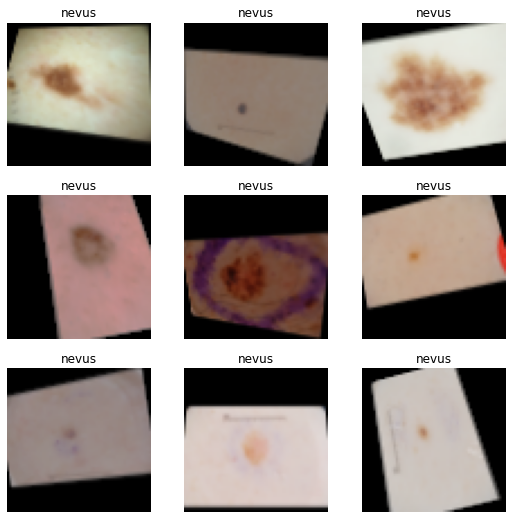

In [ ]:
dls = get_data_loader(PATH, img_size=64)
dls.train.show_batch()


  ===== Start training =====
  Epochs: 30
  Model: resnet50
  Freeze epochs: 3
  Batch size: 8
  


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.818354,1.487326,0.500000,0.433256,09:07
1,1.373025,1.525856,0.600000,0.468009,05:51
2,1.038739,1.280746,0.453333,0.409199,05:49


Better model found at epoch 0 with f1_score value: 0.43325568755338145.


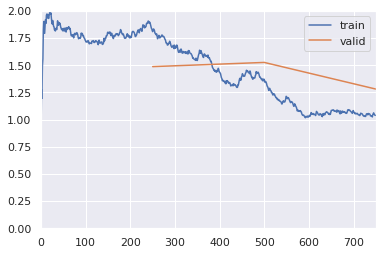

Better model found at epoch 1 with f1_score value: 0.4680094428134742.


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.993411,1.036788,0.613333,0.490171,05:52
1,0.960175,1.035706,0.560000,0.428924,05:53
2,0.838168,0.846256,0.626667,0.505413,05:53
3,0.844408,0.932068,0.633333,0.497824,05:56
4,0.806643,0.852031,0.586667,0.407617,05:52
5,0.768658,0.810168,0.653333,0.475247,05:53
6,0.775145,0.870401,0.646667,0.464192,05:55
7,0.708651,0.775834,0.653333,0.499770,05:55
8,0.732280,0.913926,0.646667,0.513529,05:56
9,0.721822,0.784320,0.646667,0.511580,05:55


Better model found at epoch 0 with f1_score value: 0.4901709401709402.


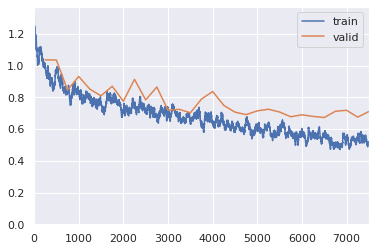

Better model found at epoch 2 with f1_score value: 0.5054131054131054.
Better model found at epoch 8 with f1_score value: 0.513529317450886.
Better model found at epoch 10 with f1_score value: 0.560627109518097.
Better model found at epoch 11 with f1_score value: 0.5829236152636591.
Better model found at epoch 17 with f1_score value: 0.6391564116283218.
Better model found at epoch 18 with f1_score value: 0.641819533123881.


                      precision    recall  f1-score   support

            melanoma       0.62      0.33      0.43        30
               nevus       0.69      0.87      0.77        78
seborrheic_keratosis       0.78      0.67      0.72        42

            accuracy                           0.71       150
           macro avg       0.70      0.62      0.64       150
        weighted avg       0.70      0.71      0.69       150

Most confused
                              confused
0                (melanoma, nevus, 17)
1    (seborrheic_keratosis, nevus, 13)
2                 (nevus, melanoma, 5)
3     (nevus, seborrheic_keratosis, 5)
4  (melanoma, seborrheic_keratosis, 3)


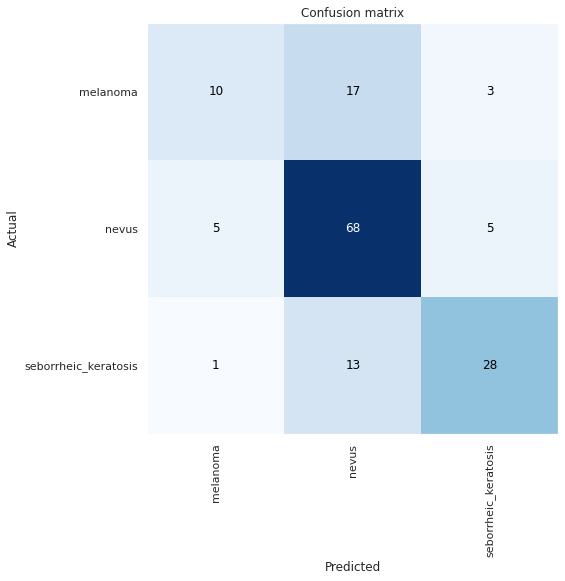

In [ ]:
dls, train = train_model(PATH, epochs=30)

# **Valuable information from the paper**
**Paper**: [Skin lesion analysis toward melanoma detection](https://arxiv.org/pdf/1710.05006.pdf)<br>
**Evaluation metric**: AUC/ROC


This paper performs three tasks:
- lesion segmentation -> binary masks with 128 threshold (`1 if x > 128 else 0`)
- dermoscopic feature classification 
- disease classification 

In [ ]:
# change the tracker to accuracy & rocauc score 
# also add early stopping & add grayscale
from sklearn.metrics import roc_auc_score

def to_grayscale(img):
  return img.convert('L')

class GrayScaleTfm(Transform):
  def encodes(self, img: Image.Image):
    return to_grayscale(img)

# create a dataloader 
def get_data_loader(path, bs=8, img_size=64, shuffle=True):
  datablock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        get_items=partial(get_image_files, folders=['train', 'val']),
                        splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                        get_y=parent_label,
                        item_tfms=[GrayScaleTfm(order=0), 
                                   Resize((img_size, img_size), method='pad', pad_mode='zeros', order=1), 
                                   ToTensor()],
                        batch_tfms=[*aug_transforms(flip_vert=True, max_rotate=15, 
                                                    pad_mode='zeros', max_lighting=0.6,
                                                    batch=True, ), 
                                   Normalize.from_stats(*imagenet_stats)])
  return datablock.dataloaders(path, bs=bs, drop_last=True, shuffle=shuffle)


def train_model(path, bs=8, img_size=64, shuffle=True, 
                freeze=3, epochs=10, model=resnet50):
  """
  Train and save best model. 
    :param path:     Path to a folder (has to have train/val folders)
    :param bs:       Batch size, default=16
    :param img_size: Image size, default: 256x256
    :param shuffle:  Whether to shuffle data, default: true
    :param freeze:   Number of epochs to train for with frozen layers, default=3
    :param epochs:   Number of epochs to train the whole model for, default=10
    :param model:    Model to train with, default=ResNet50
   
  :return: DataLoader (dls) and trained model (learn)
  """
  model_name = str(model).split(' ')[1]

  print(f"""
  ===== Start training =====
  Epochs: {epochs}
  Model: {model_name}
  Freeze epochs: {freeze}
  Batch size: {bs}
  """)
  
  # get the dataloader 
  dls = get_data_loader(path, bs, img_size, shuffle)
  # create a model, save with the highest accuracy and F1 score
  learn = cnn_learner(dls, model, metrics=[accuracy, AccumMetric(mean_auc, flatten=False)],
                      cbs=[SaveModelCallback(monitor='mean_auc', fname='best-model', comp=np.greater),
                           EarlyStoppingCallback(patience=5)])
  # freeze and train
  learn.fine_tune(epochs, freeze_epochs=freeze, 
                  cbs=[ShowGraphCallback(), TrackerCallback()])
  # plot confusion matrix and classification report
  plot_results(learn)

  # save checkpoint
  if not os.path.exists(os.path.join(path, 'checkpoints')):
    os.mkdir(os.path.join(path, 'checkpoints'))
  # get the unique model name 
  acc = round(learn.final_record[1], 2)
  name = model_name + '_' + str(acc) + 'acc'
  learn.save(os.path.join(path, 'checkpoints', name))
  
  # return DataLoader and trained model
  return dls, learn


def mean_auc(preds, targs, labels=range(3)):
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

In [ ]:
dls = get_data_loader(PATH)

learn =  Learner(dls, 
                effnet_B5, 
                loss_func=BCEWithLogitsLossFlat(),
                metrics=)


  ===== Start training =====
  Epochs: 30
  Model: resnet50
  Freeze epochs: 3
  Batch size: 4
  


epoch,train_loss,valid_loss,accuracy,mean_auc,time


IndexError: ignored